In [168]:
from pathlib import Path
import geopandas as gpd
import os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import plotly_express as px
import plotly.graph_objects as go
import plotly
import shapely.geometry
from shapely.geometry import mapping
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
import plotly.express as px
import missingno as msno
from scipy import spatial

import warnings
warnings.filterwarnings("ignore")


*Input Data*

In [176]:
base_dir = Path(f'A:/ANSU/6_Tasks/2203_Segura/')

crop = base_dir / Path(f'1_Documents/SR AH 2020-21 desagregado leñosos/Cultivos_regados_AH2021_v6.shp')
crop = gpd.read_file(crop)
df = pd.DataFrame(crop)

*Check columns and unique values*

In [177]:
# iterating the columns
for col in crop.columns:print(col)

# get unique values in dataframe
print((crop.C_AH2021.unique()))
print((crop.COSECHAS.unique()))
print((crop.Cat_L_SP.unique()))

Superficie
C20_M10
C20_M11
C20_M12
C21_M01
C21_M02
C21_M03
C21_M04
C21_M05
C21_M06
C21_M07
C21_M08
C21_M09
HI2021
HP2021
HV2021
HO20
C_AH2021
MESES_RIEG
COSECHAS
Cat_L_SP
geometry
[1 0 2 3 4 5]
['HU' 'HP' 'V' 'HV2' 'HV' 'HO' 'HI' 'HV3' 'INV' 'H2' 'H3' 'LBC' 'CIT'
 'ALM' 'OV' 'FR' 'VP' 'FRj' 'CITj']
[None 'LBC' 'CIT' 'ALM' 'OV' 'FR' 'CIT?' 'VP' 'FRj' 'CITj']


*1) Rename columns and values*

In [178]:
# Raname Column
crop = crop.rename(columns={'HI2021':'Herb_Winter','HP2021':'Herb_Spring',
                   'HV2021':'Herb_Summer','HO20':'Herb_Autumn','C_AH2021':'Seasons',
                   'MESES_RIEG':'TotalCropMonths', 'COSECHAS':'NumberHarvest',
                   'Cat_L_SP':'TreeType'})

# Rename values in TreeType column
crop['TreeType_T'] = crop['TreeType'].replace({'CIT':'Citrus', 'OV':'Olive tree','ALM':'Almond tree',
                                             'FRj':'Young Fruit Tree','LBC':'Low Density Tree Cover',
                                             'CITj':'Young Citrus', 'VP':'Vineyard','FR':'Fruit Tree',
                                             'CIT?':'Young Citrus?'})

# Get list of months
months  = [ "C21_M01", "C21_M02", "C21_M03", "C21_M04", "C21_M05", "C21_M06", "C21_M07","C21_M08","C21_M09", "C20_M10", "C20_M11", "C20_M12"] 

# Rename values in Seasons column
crop['Seasons_T'] = crop['Seasons'].replace({'HU':'Family gardens' ,'HV':'Herbaceous irrigated in summer','HV2':'Herbaceous with double harvest (including one in summer)',
                                             'HV3':'Herbaceous with triple harvest (including one in summer)','HO':'Herbaceous irrigated in autumn',
                                             'H2':'Herbaceous with double harvest (outside summer)', 'H3':'Herbaceous with triple harvest (outside summer)',
                                             'HI':'Young Herbaceous irrigated in winter','HP':'Herbaceous irrigated in spring', 'ALM':'Almonds','INV':'Greenhouse',
                                             'CIT':'Citrus','OV':'Olivos','FRj':'Young Fruit','LBC':'Low Density Tree Cover', 'CITj':'Young Citrus',
                                             'VP':'Vineyard (table grape)','FR':'Fruit', 'V':'Vineyard'})

print(crop.TreeType_T.unique())
print(crop.Seasons_T.unique())

print(len(crop.TreeType_T.unique()))
print(len(crop.Seasons_T.unique()))

[None 'Low Density Tree Cover' 'Citrus' 'Almond tree' 'Olive tree'
 'Fruit Tree' 'Young Citrus?' 'Vineyard' 'Young Fruit Tree' 'Young Citrus']
['Family gardens' 'Herbaceous irrigated in spring' 'Vineyard'
 'Herbaceous with double harvest (including one in summer)'
 'Herbaceous irrigated in summer' 'Herbaceous irrigated in autumn'
 'Young Herbaceous irrigated in winter'
 'Herbaceous with triple harvest (including one in summer)' 'Greenhouse'
 'Herbaceous with double harvest (outside summer)'
 'Herbaceous with triple harvest (outside summer)'
 'Low Density Tree Cover' 'Citrus' 'Almonds' 'Olivos' 'Fruit'
 'Vineyard (table grape)' 'Young Fruit' 'Young Citrus']
10
19


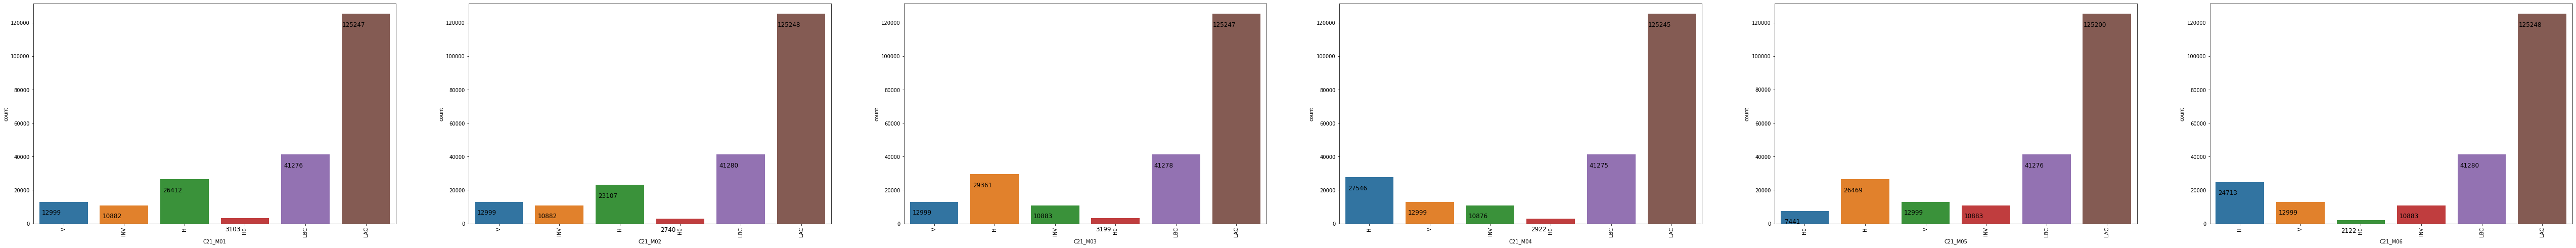

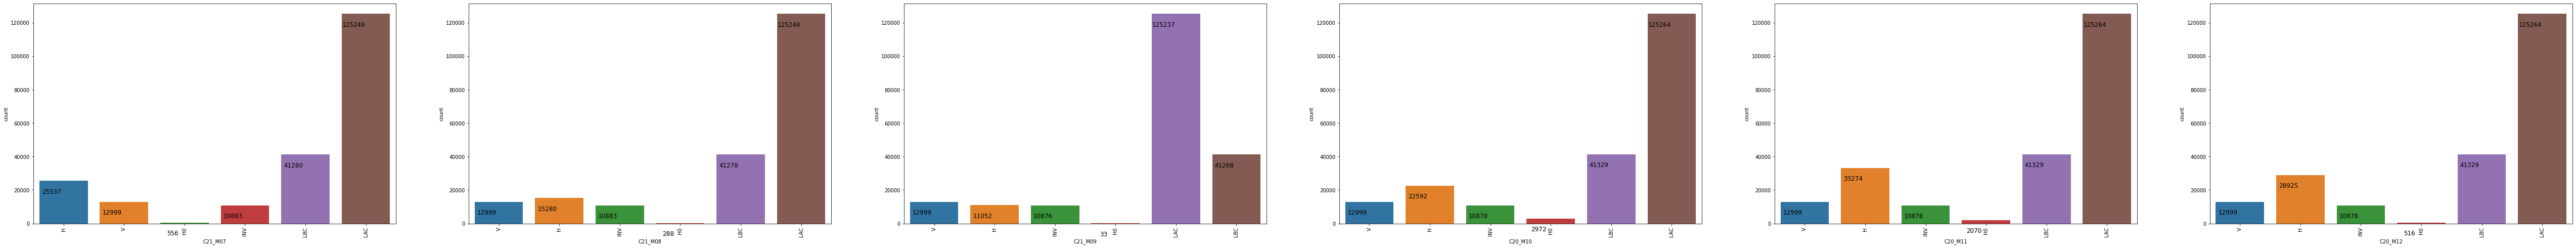

In [179]:
fig, ax = plt.subplots(1, 6, figsize=(90, 8))
for variable, subplot in zip(months[0:6], ax.flatten()):
    sns.countplot(crop[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
    for p in subplot.patches:
        subplot.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='black', size=12)
   
fig, ax = plt.subplots(1, 6, figsize=(90, 8))
for variable, subplot in zip(months[6:12], ax.flatten()):
    sns.countplot(crop[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
    for p in subplot.patches:
        subplot.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='black', size=12)
   

# 2) All Data

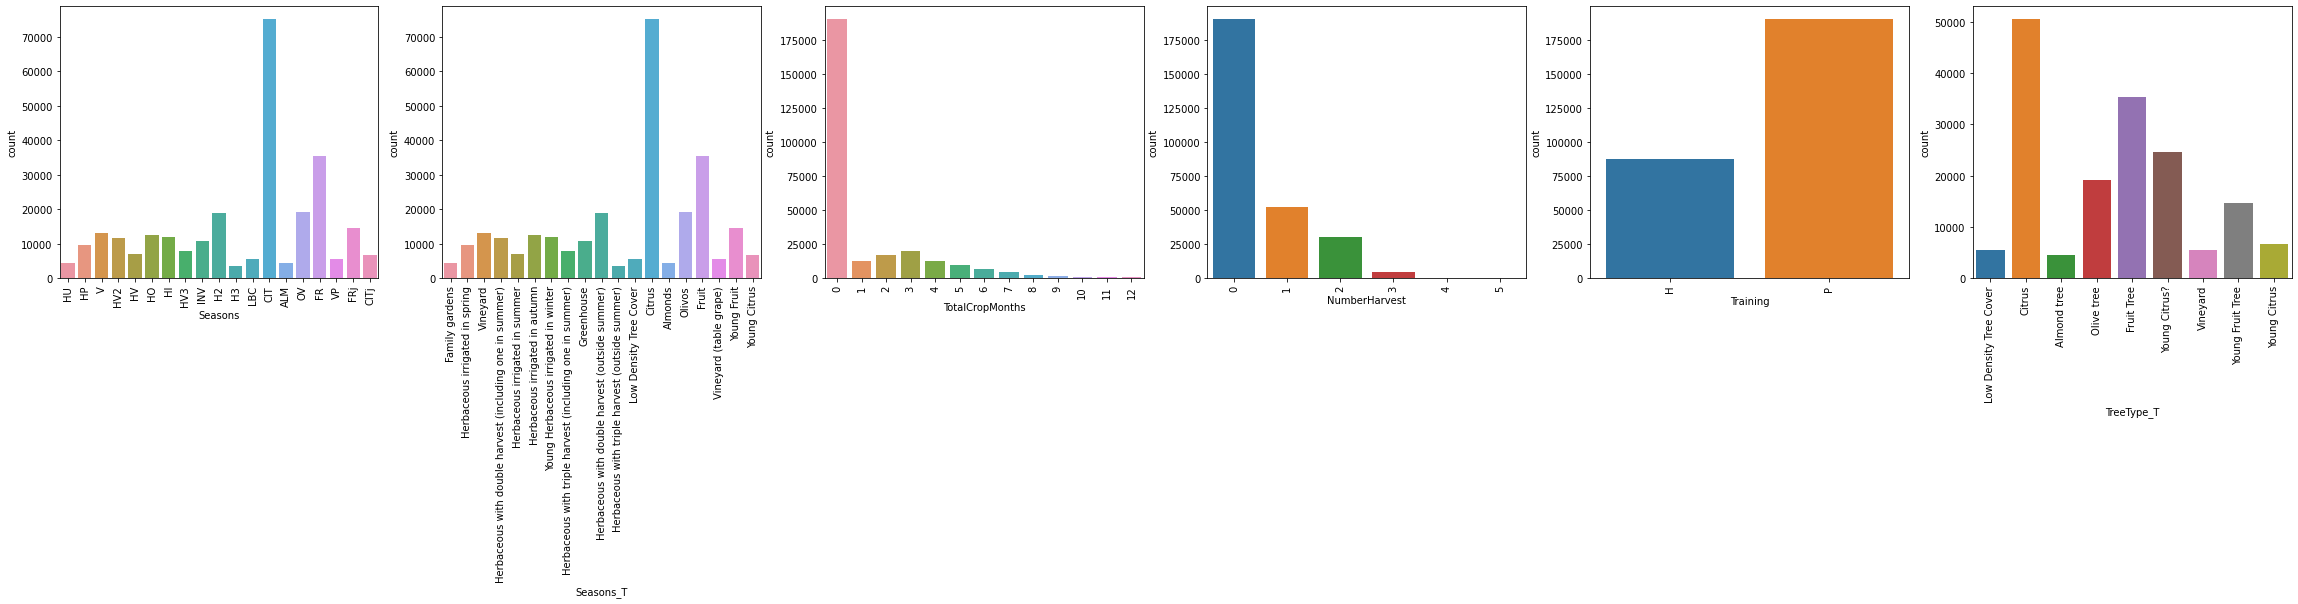

In [172]:
categorical = ['Seasons','Seasons_T', 'TotalCropMonths', 'NumberHarvest', 'Training','TreeType_T']

fig, ax = plt.subplots(1, 6, figsize=(40, 5))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(crop[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
    #for p in subplot.patches:
       # subplot.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=12)

# 3) Create Classes P/H

In [182]:
crop_months = crop[crop.columns[1:13]]
crop['Training'] = crop_months.applymap(lambda x: 'H' in str(x)).any(1)
crop['Training'] = crop['Training'].replace({True: 'H', False: 'P'})
crop


,Superficie,C20_M10,C20_M11,C20_M12,C21_M01,C21_M02,C21_M03,C21_M04,C21_M05,C21_M06,...,Herb_Summer,Herb_Autumn,Seasons,TotalCropMonths,NumberHarvest,TreeType,geometry,TreeType_T,Seasons_T,Training
0,462,None,None,None,None,None,None,None,H0,H,...,None,None,HU,3,1,None,"POLYGON ((537406.531 4216862.772, 537402.210 4...",None,Family gardens,H
1,459,None,None,None,None,None,None,None,H0,H,...,None,None,HU,3,1,None,"POLYGON ((537406.531 4216862.772, 537389.400 4...",None,Family gardens,H
2,298,None,None,None,None,None,None,None,H0,H,...,None,None,HU,3,1,None,"POLYGON ((537315.002 4216616.410, 537299.822 4...",None,Family gardens,H
3,537,None,None,None,None,None,None,None,H0,H,...,None,None,HU,3,1,None,"POLYGON ((537317.102 4216599.030, 537291.522 4...",None,Family gardens,H
4,151,None,None,None,None,None,None,None,H0,H,...,None,None,HU,3,1,None,"POLYGON ((537382.461 4216870.852, 537369.791 4...",None,Family gardens,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277690,193471,LAC,LAC,LAC,LAC,LAC,LAC,LAC,LAC,LAC,...,None,None,FR,0,0,FR,"POLYGON ((627058.821 4236663.244, 627088.205 4...",Fruit Tree,Fruit,P
277691,75622,LAC,LAC,LAC,LAC,LAC,LAC,LAC,LAC,LAC,...,None,None,FR,0,0,FR,"POLYGON ((627422.716 4237486.263, 627423.115 4...",Fruit Tree,Fruit,P
277692,55616,LAC,LAC,LAC,LAC,LAC,LAC,LAC,LAC,LAC,...,None,None,FR,0,0,FR,"POLYGON ((626810.999 4237387.847, 626954.620 4...",Fruit Tree,Fruit,P
277693,32939,LAC,LAC,LAC,LAC,LAC,LAC,LAC,LAC,LAC,...,None,None,FR,0,0,FR,"POLYGON ((626779.889 4237436.684, 626819.167 4...",Fruit Tree,Fruit,P


In [184]:
print(len(crop[crop.Training.str.contains('P')]))
print(len(crop[crop.Training.str.contains('H')]))
# crop.to_file('S:/sulova/9_Segura/3_Analysis/crop_2021.shp', driver='ESRI Shapefile') 
# crop.to_file('C:/Users/ansu/OneDrive - DHI/Desktop/crop_2021.shp', driver='ESRI Shapefile')

190258
87437


# 3) Permanent

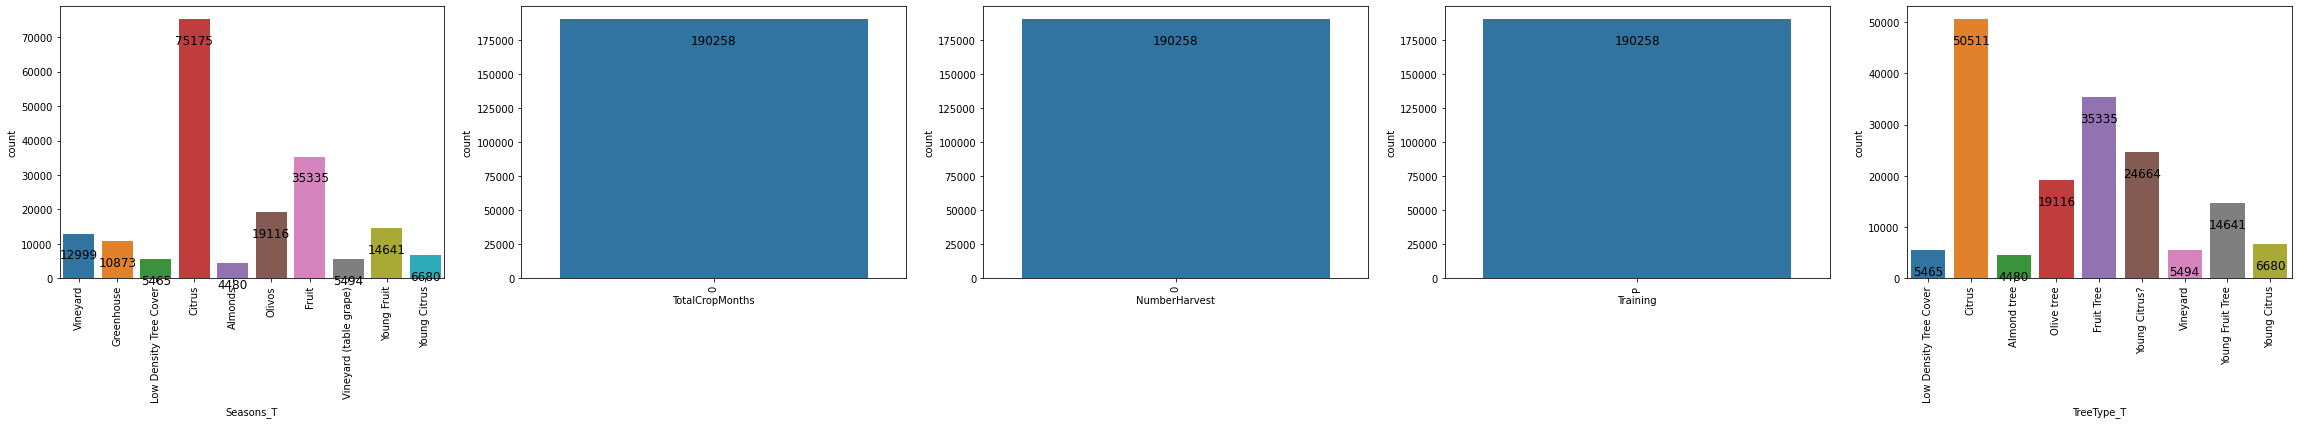

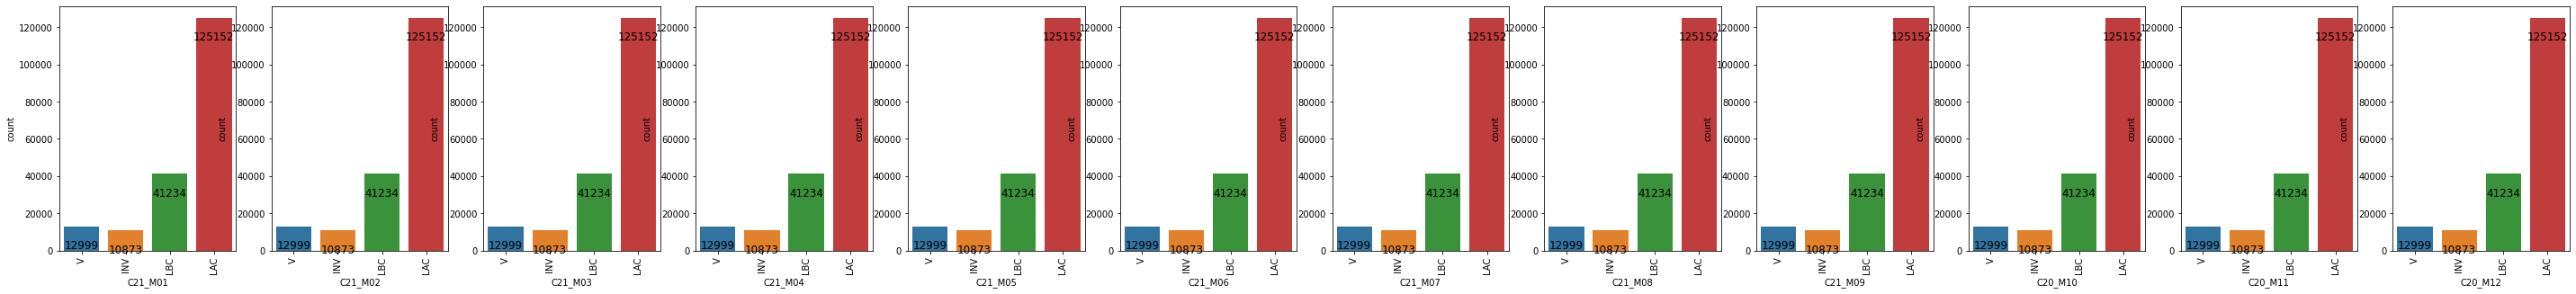

In [187]:
categorical = ['Seasons_T', 'TotalCropMonths', 'NumberHarvest', 'Training','TreeType_T']

crop_permanent = crop.loc[(crop['Training'] == 'P')]

fig, ax = plt.subplots(1, 5, figsize=(40, 5))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(crop_permanent[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
    for p in subplot.patches:
        subplot.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=12)
       

 
fig, ax = plt.subplots(1, 12, figsize=(50, 5))
for variable, subplot in zip(months, ax.flatten()):
    sns.countplot(crop_permanent[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
    for p in subplot.patches:
        subplot.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=12)      

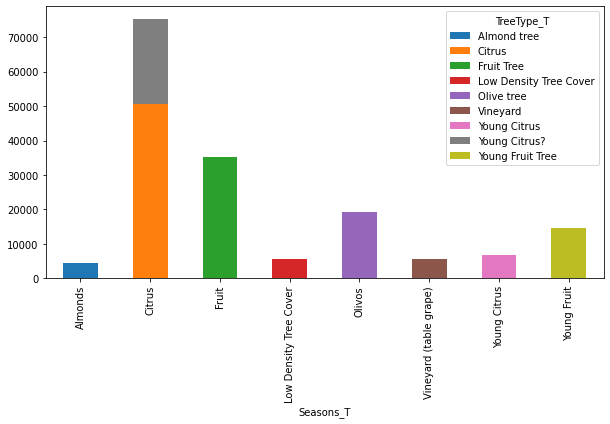

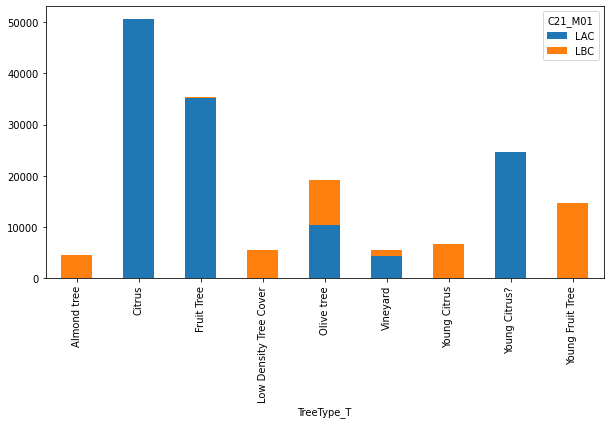

In [188]:
df = pd.crosstab(crop_permanent['Seasons_T'], crop_permanent['TreeType_T'])
df.plot(kind='bar', stacked=True, figsize = (10,5));
df = pd.crosstab(crop_permanent['TreeType_T'], crop_permanent['C21_M01'])
df.plot(kind='bar', stacked=True, figsize = (10,5));

# 4) Herbaceous

87437


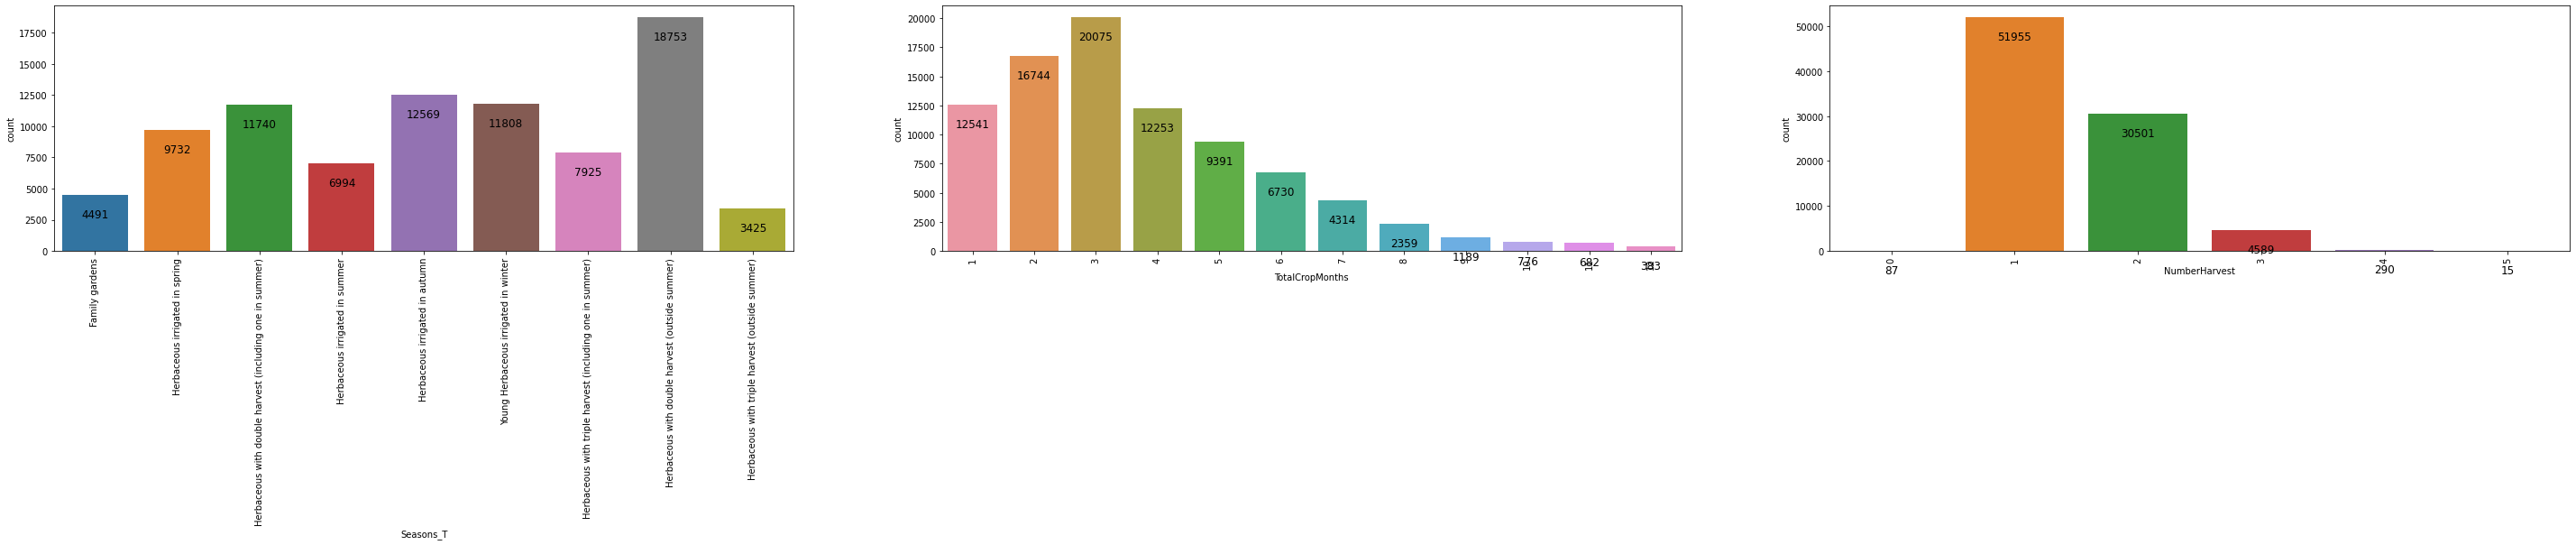

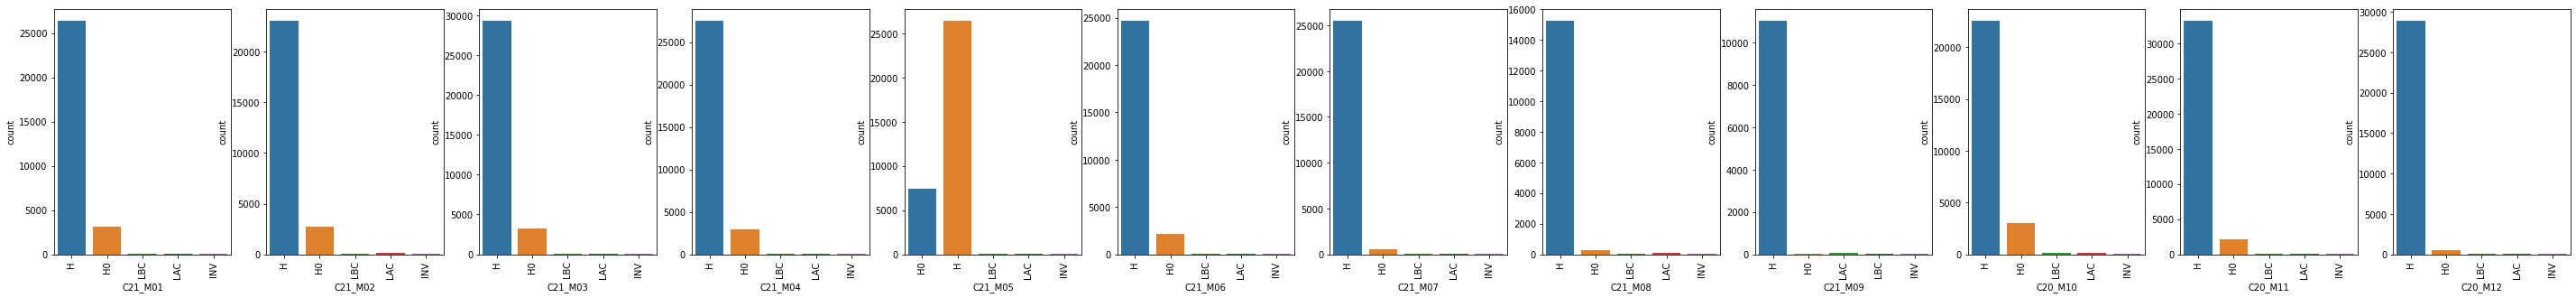

In [191]:
crop_herbaceous = crop.loc[(crop['Training'] == 'H')]
print(len(crop_herbaceous))

fig, ax = plt.subplots(1, 3, figsize=(50, 5))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(crop_herbaceous[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
    for p in subplot.patches:
        subplot.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()-0.2), ha='center', va='top', color='black', size=12)

fig, ax = plt.subplots(1, 12, figsize=(50, 5))   
for variable, subplot in zip(months, ax.flatten()):
    sns.countplot(crop_herbaceous[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
    #for p in subplot.patches:
        #subplot.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+0.5), ha='center', va='top', color='black', size=12)        

*Cleaning Permanent from Herbaceous*

In [192]:
crop_herbaceous_select = crop_herbaceous.loc[(crop_herbaceous['C21_M01'] != 'LAC')].loc[(crop_herbaceous['C21_M01'] != 'LBC')].loc[(crop_herbaceous['C21_M01'] != 'INV')]
crop_herbaceous_select = crop_herbaceous_select.loc[(crop_herbaceous_select['C21_M02'] != 'LAC')].loc[(crop_herbaceous_select['C21_M02'] != 'LBC')].loc[(crop_herbaceous_select['C21_M02'] != 'INV')]
crop_herbaceous_select = crop_herbaceous_select.loc[(crop_herbaceous_select['C21_M03'] != 'LAC')].loc[(crop_herbaceous_select['C21_M03'] != 'LBC')].loc[(crop_herbaceous_select['C21_M03'] != 'INV')]
crop_herbaceous_select = crop_herbaceous_select.loc[(crop_herbaceous_select['C21_M04'] != 'LAC')].loc[(crop_herbaceous_select['C21_M04'] != 'LBC')].loc[(crop_herbaceous_select['C21_M04'] != 'INV')]
crop_herbaceous_select = crop_herbaceous_select.loc[(crop_herbaceous_select['C21_M05'] != 'LAC')].loc[(crop_herbaceous_select['C21_M05'] != 'LBC')].loc[(crop_herbaceous_select['C21_M05'] != 'INV')]
crop_herbaceous_select = crop_herbaceous_select.loc[(crop_herbaceous_select['C21_M06'] != 'LAC')].loc[(crop_herbaceous_select['C21_M06'] != 'LBC')].loc[(crop_herbaceous_select['C21_M06'] != 'INV')]
crop_herbaceous_select = crop_herbaceous_select.loc[(crop_herbaceous_select['C21_M07'] != 'LAC')].loc[(crop_herbaceous_select['C21_M07'] != 'LBC')].loc[(crop_herbaceous_select['C21_M07'] != 'INV')]
crop_herbaceous_select = crop_herbaceous_select.loc[(crop_herbaceous_select['C21_M08'] != 'LAC')].loc[(crop_herbaceous_select['C21_M08'] != 'LBC')].loc[(crop_herbaceous_select['C21_M08'] != 'INV')]
crop_herbaceous_select = crop_herbaceous_select.loc[(crop_herbaceous_select['C21_M09'] != 'LAC')].loc[(crop_herbaceous_select['C21_M09'] != 'LBC')].loc[(crop_herbaceous_select['C21_M09'] != 'INV')]
crop_herbaceous_select = crop_herbaceous_select.loc[(crop_herbaceous_select['C20_M10'] != 'LAC')].loc[(crop_herbaceous_select['C20_M10'] != 'LBC')].loc[(crop_herbaceous_select['C20_M10'] != 'INV')]
crop_herbaceous_select = crop_herbaceous_select.loc[(crop_herbaceous_select['C20_M11'] != 'LAC')].loc[(crop_herbaceous_select['C20_M11'] != 'LBC')].loc[(crop_herbaceous_select['C20_M11'] != 'INV')]
crop_herbaceous_select = crop_herbaceous_select.loc[(crop_herbaceous_select['C20_M12'] != 'LAC')].loc[(crop_herbaceous_select['C20_M12'] != 'LBC')].loc[(crop_herbaceous_select['C20_M12'] != 'INV')]
crop_herbaceous_month = crop_herbaceous_select[crop_herbaceous_select.columns[0:25]]
print(len(crop_herbaceous))
print(len(crop_herbaceous_month))



87437
87133


In [193]:
# Rename values in TreeType column
crop_herbaceous_month['C21_M01'] = crop_herbaceous_month['C21_M01'].replace({'H0':'H', 'H':'H'})
crop_herbaceous_month['C21_M02'] = crop_herbaceous_month['C21_M02'].replace({'H0':'H', 'H':'H'})
crop_herbaceous_month['C21_M03'] = crop_herbaceous_month['C21_M03'].replace({'H0':'H', 'H':'H'})
crop_herbaceous_month['C21_M04'] = crop_herbaceous_month['C21_M04'].replace({'H0':'H', 'H':'H'})
crop_herbaceous_month['C21_M05'] = crop_herbaceous_month['C21_M05'].replace({'H0':'H', 'H':'H'})
crop_herbaceous_month['C21_M06'] = crop_herbaceous_month['C21_M06'].replace({'H0':'H', 'H':'H'})
crop_herbaceous_month['C21_M07'] = crop_herbaceous_month['C21_M07'].replace({'H0':'H', 'H':'H'})
crop_herbaceous_month['C21_M08'] = crop_herbaceous_month['C21_M08'].replace({'H0':'H', 'H':'H'})
crop_herbaceous_month['C21_M09'] = crop_herbaceous_month['C21_M09'].replace({'H0':'H', 'H':'H'})
crop_herbaceous_month['C20_M10'] = crop_herbaceous_month['C20_M10'].replace({'H0':'H', 'H':'H'})
crop_herbaceous_month['C20_M11'] = crop_herbaceous_month['C20_M11'].replace({'H0':'H', 'H':'H'})
crop_herbaceous_month['C20_M12'] = crop_herbaceous_month['C20_M12'].replace({'H0':'H', 'H':'H'})

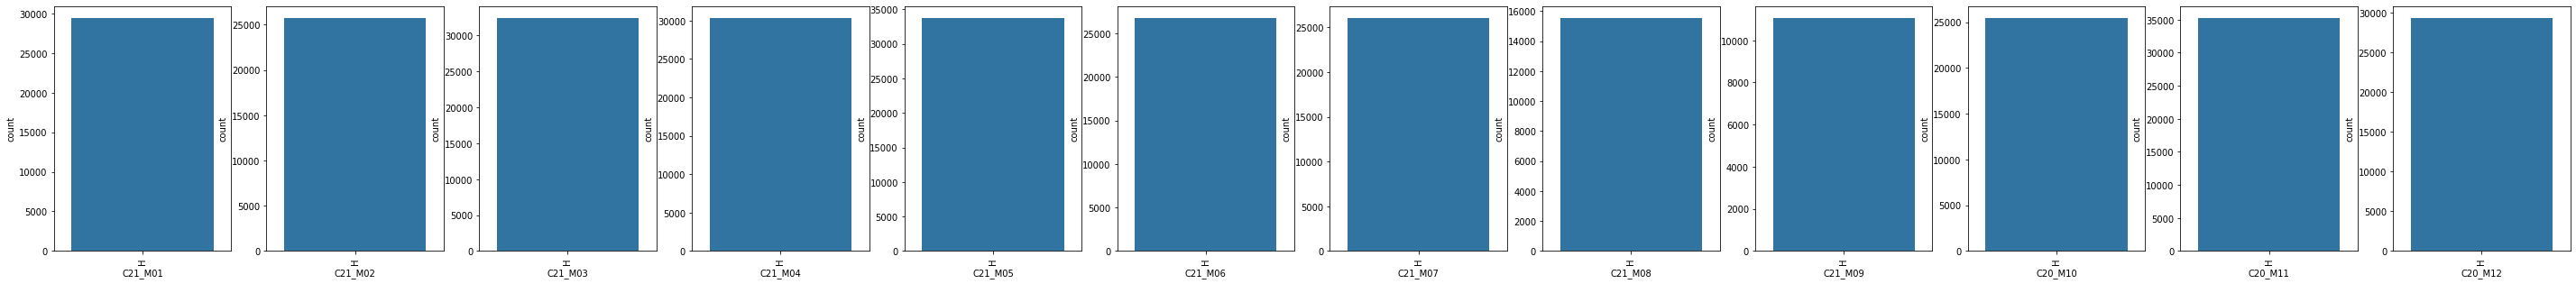

In [198]:
fig, ax = plt.subplots(1, 12, figsize=(50, 5))   
for variable, subplot in zip(months, ax.flatten()):
    sns.countplot(crop_herbaceous_month[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [199]:
# crop_herbaceous_month = crop_herbaceous_select[crop_herbaceous_select.columns[1:13]]
crop_herbaceous_month = crop_herbaceous_month[['C21_M01', 'C21_M02','C21_M03','C21_M04','C21_M05','C21_M06','C21_M07','C21_M08','C21_M09','C20_M10','C20_M11','C20_M12','geometry']]
crop_herbaceous_month


,C21_M01,C21_M02,C21_M03,C21_M04,C21_M05,C21_M06,C21_M07,C21_M08,C21_M09,C20_M10,C20_M11,C20_M12,geometry
0,None,None,None,None,H,H,H,None,None,None,None,None,"POLYGON ((537406.531 4216862.772, 537402.210 4..."
1,None,None,None,None,H,H,H,None,None,None,None,None,"POLYGON ((537406.531 4216862.772, 537389.400 4..."
2,None,None,None,None,H,H,H,None,None,None,None,None,"POLYGON ((537315.002 4216616.410, 537299.822 4..."
3,None,None,None,None,H,H,H,None,None,None,None,None,"POLYGON ((537317.102 4216599.030, 537291.522 4..."
4,None,None,None,None,H,H,H,None,None,None,None,None,"POLYGON ((537382.461 4216870.852, 537369.791 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111279,None,None,None,None,None,H,H,None,H,None,None,None,"POLYGON ((667229.711 4269069.502, 667238.800 4..."
111280,None,None,None,None,H,None,None,None,None,H,H,None,"POLYGON ((668603.895 4269024.126, 668612.616 4..."
111291,None,None,None,None,None,H,H,None,H,H,None,None,"POLYGON ((667304.560 4269024.126, 667310.029 4..."
111301,None,None,None,None,None,None,None,H,H,H,H,None,"POLYGON ((665993.412 4268914.945, 665988.852 4..."


*Save Herbaceous shp*

In [166]:
# crop_herbaceous_month.to_file('C:/Users/ansu/OneDrive - DHI/Desktop/crop_2021_month_H.shp', driver='ESRI Shapefile')

C:\Users\ansu\Anaconda3\envs\playground\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


*Analysis for fun*

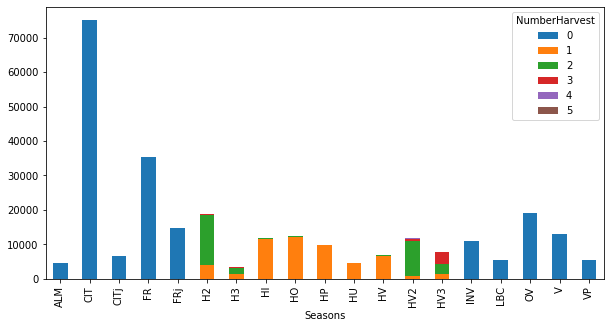

In [206]:
df = pd.crosstab(crop['Seasons'], crop['NumberHarvest'])
df.plot(kind='bar', stacked=True, figsize = (10,5));

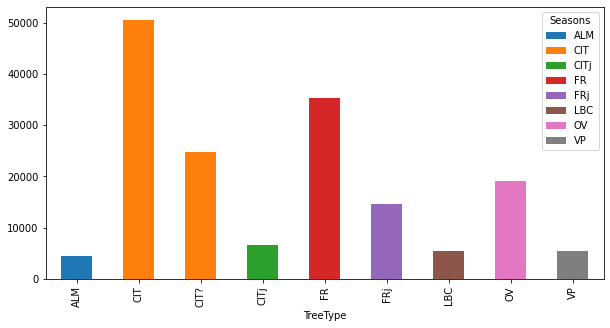

In [205]:
df = pd.crosstab(crop['TreeType'], crop['Seasons'])
df.plot(kind='bar', stacked=True, figsize = (10,5));